# Разработка системы распознавания предметов интерьера в потоковом видео

## Выявление частоты классов в датасете

In [118]:
import os
import shutil

import numpy as np
import pandas as pd

import seaborn as sns
sns.set(style="white")

%matplotlib inline
import matplotlib.pyplot as plt 

from skimage.io import imshow, imread, imsave

In [45]:
index_old_to_new = pd.read_csv('data/ADE20K_filtred/index_old_to_new.csv', 
                               header=None).rename(columns={0: 'old', 1:'new'})

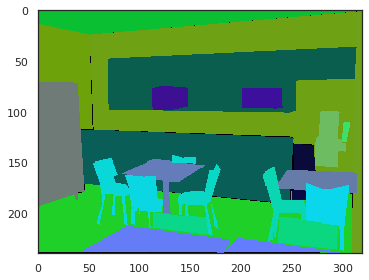

In [46]:
dir_path = 'data/ADE20K_filtred/images/train/b/breakroom/'
img = imread(dir_path + 'ADE_train_00004524.jpg')
seg = imread(dir_path + "ADE_train_00004524_seg.png")
imshow(seg)

In [47]:
class SegEncoder:
    def __init__(self, objectnames_path):
        with open(objectnames_path, 'r') as f:
            self.obj_names = f.readline().split("\t")
        self.obj_names = list(map(lambda name: name.strip("\'"), self.obj_names))
    
    def get_class_index(self, pixel):
        R = pixel[0]
        G = pixel[1]
        B = pixel[2]
        return int(R / 10 * 256 + G) - 1
    
    def get_class(self, pixel):
        return self.obj_names[self.get_class_index(pixel)]
    
segEncoder = SegEncoder('data/ADE20K_filtred/objectnames.txt')

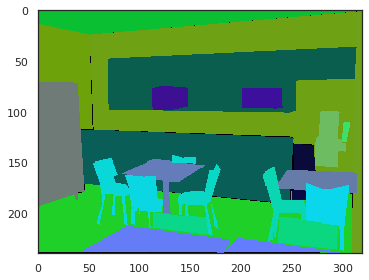

In [49]:
imshow(remove_useless(seg))

In [88]:
def get_encoded_seg(seg):
    new_seg = seg[:, :, 0].copy()
    for i in range(new_seg.shape[0]):
        for j in range(new_seg.shape[1]):
            pixel = seg[i, j]
            class_index = segEncoder.get_class_index(pixel)
            if class_index in index_old_to_new.old.to_numpy():
                new_seg[i][j] = np.uint8(index_old_to_new[index_old_to_new.old == class_index].new.iloc[0])
            else:
                new_seg[i][j] = 0

        if i % 100 == 0: #progress bar
            print(str(i) + '/' + str(new_seg.shape[0]))
    print("Done")
    return new_seg

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 19.8 µs


In [89]:
%%time
new_seg = get_encoded_seg(seg)

0/240
100/240
200/240
CPU times: user 26.9 s, sys: 224 ms, total: 27.2 s
Wall time: 25.8 s


Посмотрим на закодированную картинку

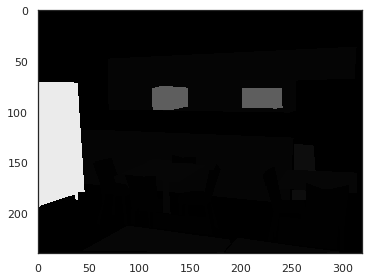

In [93]:
imshow(new_seg)

Кажется, что закодированная маска содержит не все объекты, но у нас самые частые значения от 0 до 100, что означает очень тёмный цвет

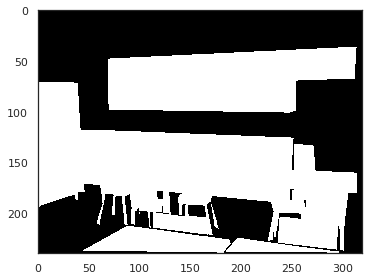

In [94]:
imshow(new_seg != 0)

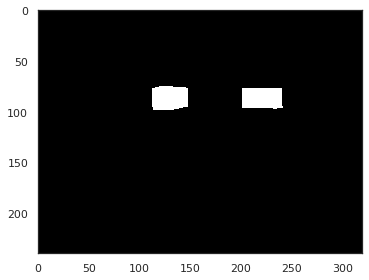

In [95]:
imshow(new_seg == 94)

### Ускорение работы

Будем считывать не в в pandas, а в обычный словарь

In [103]:
index_old_to_new_dict = dict()
with open('data/ADE20K_filtred/index_old_to_new.csv', 'r') as f:
    for line in f:
        line_arr = line.strip().split(",")
        index_old_to_new_dict[int(line_arr[0])] = int(line_arr[1])

In [124]:
def get_encoded_seg(seg):
    new_seg = seg[:, :, 0].copy()
    for i in range(new_seg.shape[0]):
        for j in range(new_seg.shape[1]):
            pixel = seg[i, j]
            class_index = segEncoder.get_class_index(pixel)
            if class_index in index_old_to_new_dict:
                new_seg[i][j] = np.uint8(index_old_to_new_dict[class_index])
            else:
                new_seg[i][j] = 0

    return new_seg

In [108]:
%%time
new_seg = get_encoded_seg(seg)

0/240
100/240
200/240
Done
CPU times: user 547 ms, sys: 2.47 ms, total: 549 ms
Wall time: 547 ms


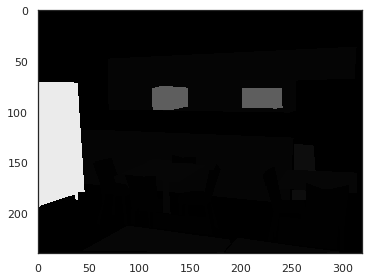

In [112]:
imshow(new_seg)

Как мы видим программа значительно ускорилась

### Генерирование новой обучающей выборки

In [116]:
def get_format(file_name):
    name_split = file_name.split("_")
    file_format = name_split[0:-1] + name_split[-1].split(".")
    ade, train_or_val, name = file_format[:3]
    extension = file_format[-1]
    
    description = 0
    parts_num = 0
    if extension == 'jpg':
        description = 'img'
    elif extension == 'txt':
        description = 'text'
    else: #png
        description = file_format[3]
        if file_format[4].isdigit():
            parts_num = int(file_format[4])
    return [name, description, train_or_val, parts_num]

In [140]:
%%time
dir_path = 'data/ADE20K_filtred/images/train/'

img_dst_train = 'data/ADE20K_formated/train/img/'
mask_dst_train = 'data/ADE20K_formated/train/mask/'

img_dst_val = 'data/ADE20K_formated/val/img/'
mask_dst_val = 'data/ADE20K_formated/val/mask/'

s = 0
for path, dirs, files in os.walk(dir_path):
        if files:
            for file in files:
                name, description, train_or_val, parts_num = get_format(file)
                
                img_dst = img_dst_train
                mask_dst = mask_dst_train
                if train_or_val == 'val':
                    img_dst = img_dst_val
                    mask_dst = mask_dst_val
                
                if description == 'img':
                    img_path = path + '/' + file
                    shutil.copyfile(img_path, img_dst + name + '.jpg')
                    s += 1
                    
                    if s % 100 == 0:
                        print(s)
                    
                elif description == 'seg':
                    seg_path = path + '/' + file
                    seg = imread(seg_path)
                    new_seg = get_encoded_seg(seg)
                    imsave(mask_dst + name + '.png', new_seg)
                
print("Done")

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00016708.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00016149.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00016856.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00016199.png is a low contrast image
  warn('%s is a low contrast image' % fname)


100
200
300


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/val/mask/00001454.png is a low contrast image
  warn('%s is a low contrast image' % fname)


400
500
600
700
800


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00010641.png is a low contrast image
  warn('%s is a low contrast image' % fname)


900
1000


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00007576.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00007569.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00007568.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00007572.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/val/mask/00001338.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda

1100


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00007536.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00007540.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/val/mask/00000338.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00007531.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00007562.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda

1200
1300


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00015186.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1400


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00015413.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1500
1600


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00014148.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00014149.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1700


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00015945.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00015802.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00015809.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1800


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/val/mask/00001446.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00006843.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1900


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00007332.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00007331.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2000


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00007047.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00006964.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2100


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00006938.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00007154.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00006936.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2200


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/val/mask/00000312.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00007242.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00007101.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2300


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00006904.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/val/mask/00001316.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00007115.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00006908.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2400


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00006742.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00006763.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00006751.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2500


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00007373.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2600


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00006657.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00006665.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00006654.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00006653.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00011767.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anacon

2700


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00012223.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00012228.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00012240.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00012217.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00012226.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anacon

2800


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00013933.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2900


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00008830.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00009454.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00009463.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00009459.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3000
3100


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00009585.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00009606.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3200


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00009519.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00019922.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3300


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00019693.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3400


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00019653.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00019607.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00019670.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3500


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00005613.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00005641.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00005638.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3600


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00005542.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00005100.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00005102.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00006103.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00006033.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3700


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00006083.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00005979.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00006013.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00006027.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00005999.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anacon

3800


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00006069.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00006132.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/val/mask/00001270.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00006113.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00005167.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda

3900


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00005187.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00005197.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00005193.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4000
4100


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00005972.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00005977.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00005975.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00008802.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4200


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00008462.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00008480.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4300


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00008373.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4400
4500


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00014791.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00014799.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00014812.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00014902.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00014800.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4600


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00007928.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00008297.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00019387.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4700


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00019209.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00019101.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00000961.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00004456.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4800


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00004457.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00004441.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00004450.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00002477.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00002476.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anacon

4900


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00004388.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00004124.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5000
5100
5200
5300
5400
5500
5600
5700
5800
5900


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00003531.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6000
6100


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00003766.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6200


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00003905.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6300
6400


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00004264.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6500


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00002382.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00004294.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00004302.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00003176.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6600
6700
6800
6900
7000
7100
7200
7300


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00002293.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00002272.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00009871.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7400


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/val/mask/00000444.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00009769.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00001691.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00001695.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00001689.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda

7500


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00001634.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00001651.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00001670.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00001663.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00001683.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anacon

7600


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00001808.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00001908.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/val/mask/00000048.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00001904.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00001906.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda

7700


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00001958.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00001899.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00001894.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00011524.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7800


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00011563.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7900


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: data/ADE20K_formated/train/mask/00010861.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8000
8100
8200
8300
8400
8500
8600
8700
Done
CPU times: user 20h 58min 11s, sys: 22.7 s, total: 20h 58min 34s
Wall time: 21h 2min 18s
